In [1]:
# download data from provided link
!wget -nc https://www.dropbox.com/s/lkd0eklmi64m9xm/AirlineTweets.csv

File ‘AirlineTweets.csv’ already there; not retrieving.



In [2]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('AirlineTweets.csv')

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:
df = df[['airline_sentiment','text']]

<Axes: >

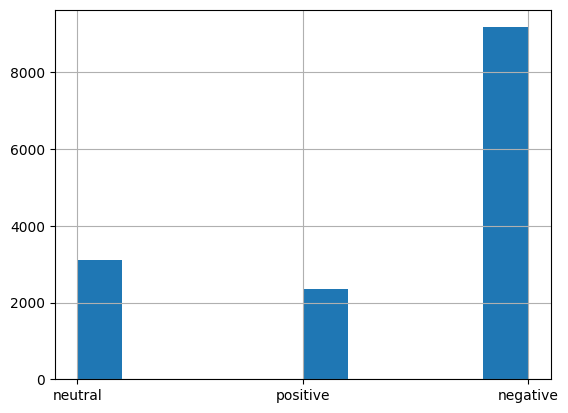

In [7]:
df['airline_sentiment'].hist()

In [8]:
target_map = { 'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [9]:
df1 = df[['text','target']]
df1.columns = ['sentence','label']
df1.to_csv('data.csv', index = False)

In [10]:
!pip install datasets


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [11]:
from datasets import load_dataset
raw_dataset = load_dataset("csv", data_files = 'data.csv')

/Users/larawehbe/Documents/Lara/Courses/LLMsCourse/Notebooks/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 14640 examples [00:00, 133214.33 examples/s]


In [12]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [13]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [14]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [15]:
# # if we have multiple csv files
# raw_dataset = load_dataset('csv', data_files = ['file1.csv','file2.csv'])

In [16]:
# raw_dataset = load_dataset('csv', 
#               data_files = { 'train': ['train1.csv','train2.csv'],
#                              'test': 'test.csv'})

### Tokenize The Data

In [17]:
# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased'
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

In [18]:
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

In [19]:
tokenized_dataset = split.map(tokenize_fn, batched = True)

Map: 100%|██████████| 4392/4392 [00:00<00:00, 41167.13 examples/s]


### Choose pretrained model

In [20]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

### Define a fine-tuning architecture

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
!pip install torchinfo

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [23]:
from torchinfo import summary
summary(model)


Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   22,268,928
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

### Compile the model

In [30]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

/Users/larawehbe/Documents/Lara/Courses/LLMsCourse/Notebooks/venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [28]:
import torch
print(torch.backends.mps.is_available())  # Should return True


True


In [ ]:
device = torch.device("mps")
model.to(device)

In [31]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

/var/folders/qt/8nj7tb591mx9xtqkgz7mjyjh0000gn/T/ipykernel_6133/1048591017.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model,


In [ ]:
trainer.train()

  2%|▏         | 39/1923 [00:37<1:25:23,  2.72s/it]

In [ ]:
! ls training_dir

### Evaluate the model

In [ ]:
from transformers import pipeline

In [ ]:
saved_model = pipeline('text-classification',
                       model = 'training_dir/checkpoint-1282')

In [ ]:
split['test']

In [ ]:
predictions = saved_model(split['test']['sentence'])

In [ ]:
predictions[:10]

#### we are getting list of dictionaries. Next we will write a function to get labels only.

In [ ]:
def get_label(d):
  return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in predictions]

In [ ]:
print("acc:",accuracy_score(split['test']['label'], predictions))

In [ ]:
print("f1:",f1_score(split['test']['label'], predictions, average = 'macro'))

In [ ]:
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'],predictions, normalize = 'true')
plot_cm(cm)